# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

**Please add your shareable Colab link here:** https://colab.research.google.com/drive/1MNrYD7EigNvRATYxrYa_muYIxZJFE11-?usp=sharing

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset


EPS = 1.0e-7

import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

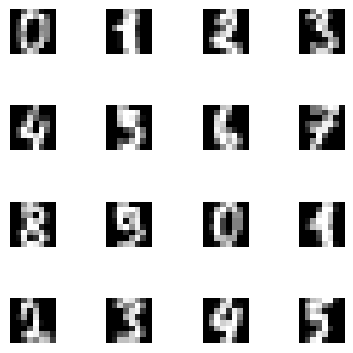

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [14]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        s = self.classnet(x)
        y_pred = torch.argmax(s, dim=1)

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        y_pred = self.classnet(x)
        loss = self.nll(y_pred, y)
        # ------
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
1/n*∑ log p(yi | xi)

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** yes because the logsoftmax gives log likelihoods which are more stable than small numbers from softmax and that works good with the nn.NLLLoss

### 2.2 Evaluation

In [20]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model",weights_only=False)

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.9001826477050782, val ce=0.13714285714285715
Epoch: 10, val nll=0.13262344428471157, val ce=0.02857142857142857
Epoch: 20, val nll=0.09977001428604126, val ce=0.025714285714285714
Epoch: 30, val nll=0.08784679378782, val ce=0.02
Epoch: 40, val nll=0.0829655270917075, val ce=0.02
Epoch: 50, val nll=0.07877671105521065, val ce=0.02
Epoch: 60, val nll=0.07717183300427029, val ce=0.02
Epoch: 70, val nll=0.07542782766478402, val ce=0.02
Epoch: 80, val nll=0.07452915515218463, val ce=0.02
Epoch: 90, val nll=0.07351407306534903, val ce=0.02
Epoch: 100, val nll=0.07257640446935382, val ce=0.02
Epoch: 110, val nll=0.07250905632972718, val ce=0.02
Epoch: 120, val nll=0.07182224307741437, val ce=0.02
Epoch: 130, val nll=0.07184358903339931, val ce=0.02
Epoch: 140, val nll=0.07203599120889391, val ce=0.02
Epoch: 150, val nll=0.07189520512308394, val ce=0.02
Epoch: 160, val nll=0.07177188864776067, val ce=0.022857142857142857
-> FINAL PERFORMANCE: nll=0.

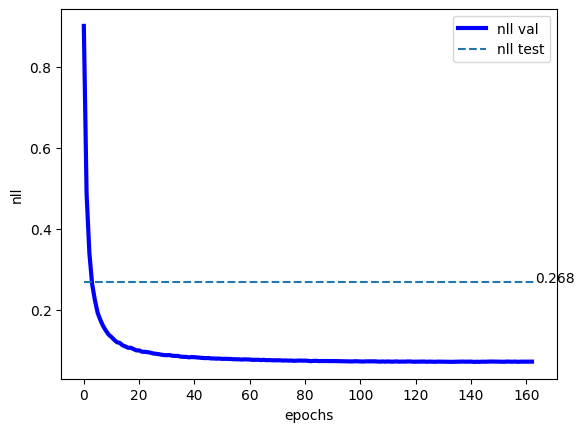

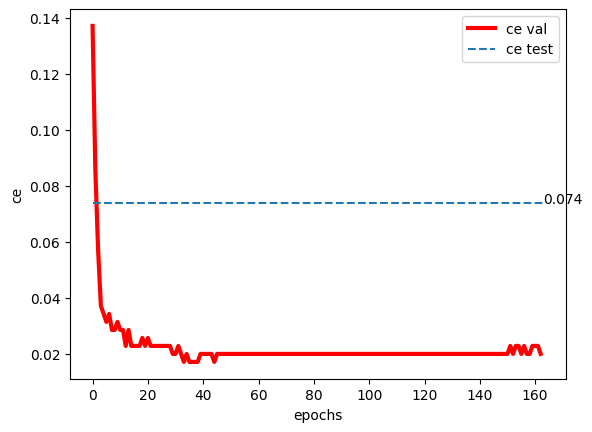


-> START classifier_cnn
Epoch: 0, val nll=1.0075364685058594, val ce=0.13428571428571429
Epoch: 10, val nll=0.12821915013449534, val ce=0.03428571428571429
Epoch: 20, val nll=0.10774471691676549, val ce=0.03428571428571429
Epoch: 30, val nll=0.09950237819126674, val ce=0.03428571428571429
Epoch: 40, val nll=0.0992140405518668, val ce=0.03428571428571429
Epoch: 50, val nll=0.09663134166172573, val ce=0.03142857142857143
Epoch: 60, val nll=0.09625844512666974, val ce=0.03142857142857143
Epoch: 70, val nll=0.09585707187652588, val ce=0.03142857142857143
Epoch: 80, val nll=0.09598432643072946, val ce=0.03142857142857143
Epoch: 90, val nll=0.09530910798481533, val ce=0.03142857142857143
Epoch: 100, val nll=0.09497954368591309, val ce=0.02857142857142857
Epoch: 110, val nll=0.09583873510360717, val ce=0.03142857142857143
Epoch: 120, val nll=0.09515469244548252, val ce=0.03142857142857143
-> FINAL PERFORMANCE: nll=0.16588035632566583, ce=0.053691275167785234


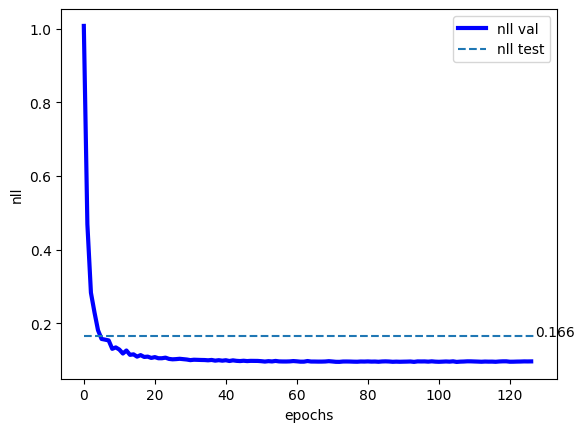

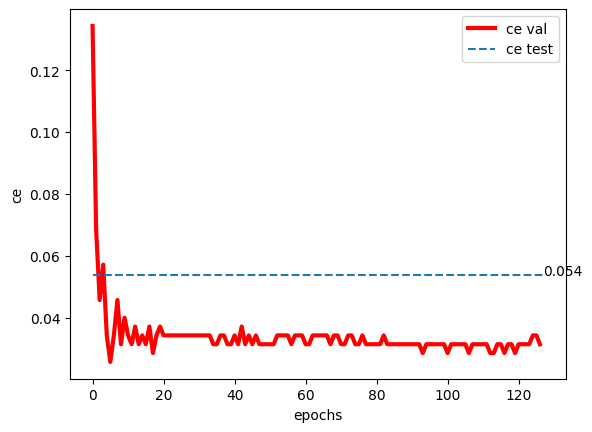

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Flatten(),
            nn.Linear(D, M),
            nn.Tanh(),
            nn.Linear(M,M),
            nn.Tanh(),
            nn.Linear(M,K),
            nn.LogSoftmax(1)
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            Reshape((1,8,8)),
            nn.Conv2d(1, num_kernels, 3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            Flatten(),
            nn.Linear(num_kernels * 4*4, M),
            nn.Tanh(),
            nn.Linear(M,M),
            nn.Tanh(),
            nn.Linear(M,K),
            nn.LogSoftmax(1),
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: The convergence of both loss fucntion are pretty much the same in shape except that the test value for the loss of the mlp is worse than that of the CNN and for the CE the convergence of the mlp is more stable but that if the CNN is faster but a bit more unstable. The CNN model also has less overfitting than the mlp because the test and val lines are much closer together

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: Because images can have thousands of pixels and mlps need to take into account all of them to get a good estimate but convolutions can generalise a bit which helps it use less computational power and it can find some hidden concepts in images which makes it perform better

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [17]:
dir_train = "/Users/m.manso/Downloads"
name = "ConvNeuralNetwork"
result_dir = "/content/gdrive/My Drive/Colab Notebooks/TEACHING/"
result_dir = os.path.join(results_dir, "results", name + "/")

# =========
# MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
result_dir = "./"  # (current folder)
# =========
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [9]:

class SVHN(Dataset):
    def __init__(self, dir_train, mode="train", transforms=None):
        """
        Here I create the svhn class that when called will download and split the data into train, val and test sets
        """
        self.mode = mode
        self.transforms = transforms

        if mode in ["train", "val"]:
          self.full_data = datasets.SVHN(root=dir_train, split="train", download=True)

          split = int(len(self.full_data) * 0.9)

          train_data, val_data = random_split(self.full_data, [split, len(self.full_data)- split])
          if mode == "train":
            self.data = train_data

          elif mode == "val":
            self.data = val_data

        elif mode == "test":
          self.data = datasets.SVHN(root=dir_train, split="test", download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        I return the items based on the index and if i need to transform the data
        """
        img, target = self.data[idx]
        if self.transforms != None:
          img = self.transforms(img)
        return (img, target)


In [10]:
transform = transforms.Compose([transforms.ToTensor()]) #I initialize the transfromation that needs to occur so from PIL or something else to tensor

# I capture the data and separate variables
train_data = SVHN(dir_train, "train", transforms=transform)
val_data = SVHN(dir_train, "val", transforms=transform)
test_data = SVHN(dir_train, "test", transforms=transform)

#I put it into a dataloader for faster access and batches
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

print(train_data[1][0].shape)

100%|██████████| 182M/182M [00:34<00:00, 5.33MB/s]
100%|██████████| 64.3M/64.3M [00:12<00:00, 5.00MB/s]


torch.Size([3, 32, 32])


In [26]:

M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 64  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [12]:
class ConvNeuralNetwork(nn.Module):
  def __init__(self):
    """
    The layers I went for is two convolutions to maxpooling to reduce it and get more features and that another time to further increase the features and decrease the picture and then a last convolution to maxpooling to further reduce and increase it I use batch normalisation to make the convolutions converge faster
    Then I flatten everything and use 1 input layer 1 hidden layer and a output layer with dropout to stop overfitting
    """
    super().__init__()
    self.nll = nn.NLLLoss(reduction="none")
    self.stack = nn.Sequential(
            nn.Conv2d(3, num_kernels, 3, padding=1), #channel = 64
            nn.BatchNorm2d(num_kernels),
            nn.ReLU(),
            nn.Conv2d(num_kernels, num_kernels, 3, padding=1), #channel = 64
            nn.BatchNorm2d(num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 16 * 16

            nn.Conv2d(num_kernels, 2 * num_kernels, 3, padding=1), #channel = 128
            nn.BatchNorm2d(2 * num_kernels),
            nn.ReLU(),
            nn.Conv2d(2 * num_kernels, 2 * num_kernels, 3, padding=1), #channel = 128
            nn.BatchNorm2d(2 * num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 8 * 8

            nn.Conv2d(2 * num_kernels, 4 * num_kernels, 3, padding=1), #channel = 256
            nn.BatchNorm2d(4 * num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 4 * 4


            Flatten(),
            nn.Linear((4 * num_kernels) * 4*4, M),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(M,M),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(M,K),
            nn.LogSoftmax(1),
        )
  def classify(self, x):
      s = self.stack(x)
      y_pred = torch.argmax(s, dim=1)

      return y_pred

  def forward(self, x, y, reduction="avg"):
      y_pred = self.stack(x)
      loss = self.nll(y_pred, y)
      if reduction == "sum":
          return loss.sum()
      else:
          return loss.mean()



In [22]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            batch = batch.to(device)#for gpu computations
            targets = targets.to(device)#for gpu computations
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [24]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model",weights_only=False)

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        test_batch = test_batch.to(device)#for gpu computations
        test_targets = test_targets.to(device)#for gpu computations
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error

Epoch: 0, val nll=1.4517528857815112, val ce=0.4795249795249795
Epoch: 10, val nll=0.4468492064813171, val ce=0.0879060879060879
Epoch: 20, val nll=0.35242028721948154, val ce=0.08613158613158613
Epoch: 30, val nll=0.09285527710181717, val ce=0.021703521703521703
Epoch: 40, val nll=0.07066349972801197, val ce=0.0171990171990172
Epoch: 50, val nll=0.050260943693441675, val ce=0.011056511056511056
Epoch: 60, val nll=0.06068540361452845, val ce=0.016653016653016654
Epoch: 70, val nll=0.06188176379905449, val ce=0.014332514332514333
Epoch: 80, val nll=0.05687499521470545, val ce=0.010510510510510511
Epoch: 90, val nll=0.057646444577387115, val ce=0.014332514332514333
Epoch: 100, val nll=0.05830435483728378, val ce=0.009418509418509418
-> FINAL PERFORMANCE: nll=0.3942313859560919, ce=0.06038721573448064


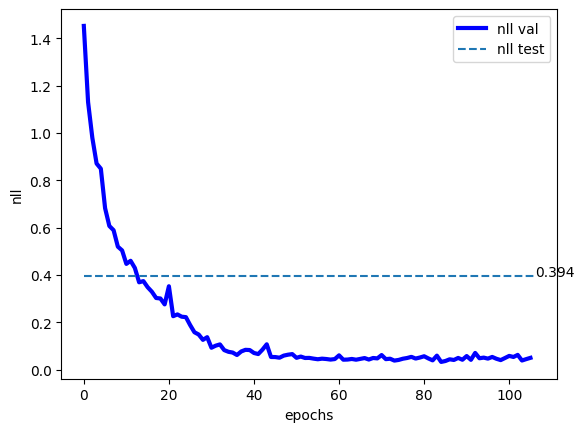

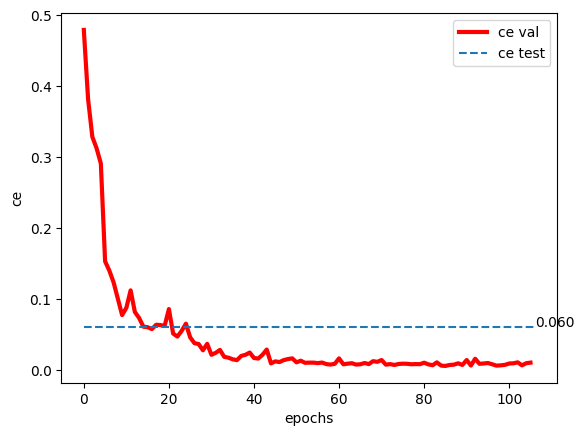

In [27]:
#I initialize the model
model = ConvNeuralNetwork().to(device)#for gpu computations

#and use a simple adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#then I train the model
nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=train_loader,
        val_loader=val_loader,
    )


#I evaluate the performance on the test set
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)

f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()

plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

The entropy loss of my model is still quite high at 0.394 which is decent but that means my model is a low confidence value than my classification implies or something to do with my softmax value. My classification error is 0.060 which means there is a little bit of overfitting but not much because the test line and val line are pretty close. With a classification error of 0.060 that means my model generalizes well.